# Image Recoloring for CVD
Kode ini berfungsi untuk melakukan pewarnaan ulang pada citra sehingga warna pada citra bisa lebih dibedakan oleh penderita buta warna merah-hijau (protanopia maupun deutranopia). Pada kode ini akan digunakan citra kupu-kupu dan bunga untuk melakukan pengujian.

In [1]:
from skimage import color, io, util, exposure
from skimage import filters, morphology
from skimage.transform import rescale
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


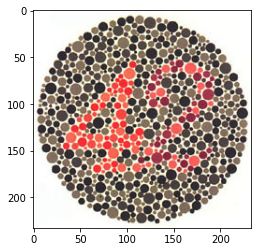

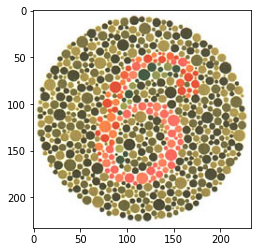

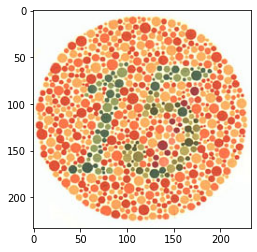

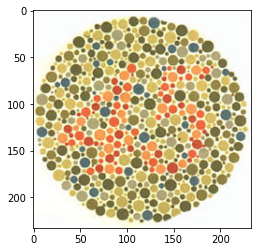

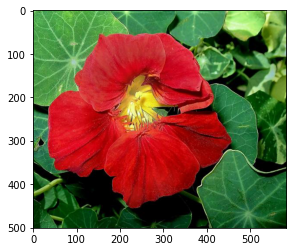

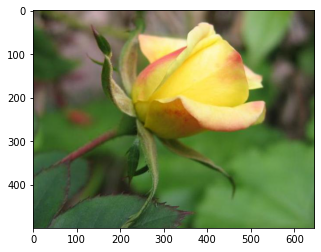

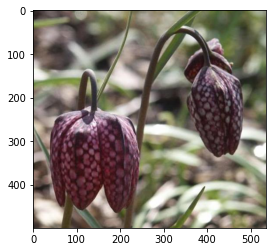

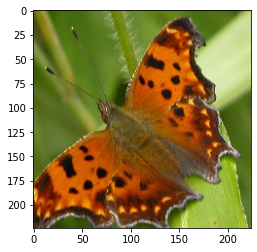

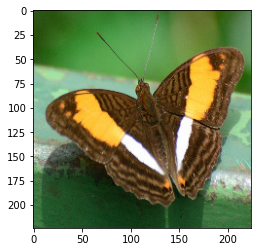

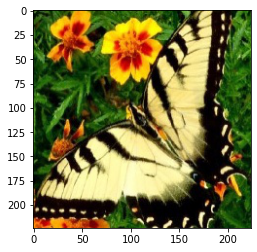

In [2]:
universal_link = 'drive/MyDrive/[Bimbingan] S1 LR/~2122Genap Naufal Tanansyah CVD Enhancement/Dataset/Images_final_original'

img_links = []
for i in range(10):
    img_link = universal_link + '/img_0' + str(i) + '.jpg'
    img_links.append(img_link)

images = []
for i in range(10):
    images.append(io.imread(img_links[i]))
    plt.imshow(images[i])
    plt.show()

## Color Spaces (RGB, xyY, dan XYZ)
Kode di bawah adalah kode yang digunakan untuk mengubah color spaces dari sebuah citra (dari RGB ke xyY dan dari xyY ke RGB). Untuk keseluruhan pengubahan, digunakan bilangan real dengan range 0.0 - 1.0

In [3]:
RGB_to_XYZ_mat = [[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]]
XYZ_to_RGB_mat = np.linalg.inv(RGB_to_XYZ_mat)

def point_RGB_to_XYZ(RGB):
    return np.dot(RGB_to_XYZ_mat, RGB)

def point_XYZ_to_RGB(XYZ):
    res = np.dot(XYZ_to_RGB_mat, XYZ)
    for i in range(3):
        if res[i] < 0:
            res[i] = 0.0
        if res[i] > 1:
            res[i] = 1.0
    return res

def point_XYZ_to_xyY(XYZ):
    X = XYZ[0]
    Y = XYZ[1]
    Z = XYZ[2]
    xyY = [0.0, 0.0, 0.0]
    if (X + Y + Z != 0):
        xyY[0] = X / (X + Y + Z)
        xyY[1] = Y / (X + Y + Z)
    else:
        xyY[0] = 0.31272660439158345
        xyY[1] = 0.3290231524027522
    xyY[2] = Y
    return xyY

def point_xyY_to_XYZ(xyY):
    x = xyY[0]
    y = xyY[1]
    Y = xyY[2]
    XYZ = [0.0, 0.0, 0.0]
    if (y != 0):
        XYZ[0] = (x * Y) / y
        XYZ[2] = ((1 - x - y) * Y) / y
    else:
        XYZ[0] = 0
        XYZ[2] = 0
    XYZ[1] = Y
    return XYZ

def point_RGB_to_xyY(RGB):
    XYZ = point_RGB_to_XYZ(RGB)
    xyY = point_XYZ_to_xyY(XYZ)
    return xyY

def point_xyY_to_RGB(xyY):
    XYZ = point_xyY_to_XYZ(xyY)
    RGB = point_XYZ_to_RGB(XYZ)

def image_RGB_to_XYZ(RGB):
    XYZ = np.zeros(RGB.shape)
    for row in range(RGB.shape[0]):
        for col in range(RGB.shape[1]):
            XYZ[row, col] = point_RGB_to_XYZ(RGB[row, col])
    return XYZ

def image_XYZ_to_RGB(XYZ):
    RGB = np.zeros(XYZ.shape)
    for row in range(XYZ.shape[0]):
        for col in range(XYZ.shape[1]):
            RGB[row, col] = point_XYZ_to_RGB(XYZ[row, col])
    return RGB

def image_XYZ_to_xyY(XYZ):
    xyY = np.zeros(XYZ.shape)
    for row in range(XYZ.shape[0]):
        for col in range(XYZ.shape[1]):
            xyY[row, col] = point_XYZ_to_xyY(XYZ[row, col])
    return xyY

def image_xyY_to_XYZ(xyY):
    XYZ = np.zeros(xyY.shape)
    for row in range(xyY.shape[0]):
        for col in range(xyY.shape[1]):
            XYZ[row, col] = point_xyY_to_XYZ(xyY[row, col])
    return XYZ

def image_RGB_to_xyY(RGB):
    XYZ = image_RGB_to_XYZ(RGB)
    xyY = image_XYZ_to_xyY(XYZ)
    return xyY

def image_xyY_to_RGB(xyY):
    XYZ = image_xyY_to_XYZ(xyY)
    RGB = image_XYZ_to_RGB(XYZ)
    return RGB

Kode bantuan untuk mengubah RGB dari range 0 s.d. 255 ke RGB dengan range 0.0 - 1.0 dan sebaliknya

In [4]:
def point_RGBi_to_RGBf(RGBi):
    RGBf = RGBi / 255
    if (RGBf < 0):
        RGBf = 0.0
    if (RGBf > 1):
        RGBf = 1.0
    return RGBf

def point_RGBf_to_RGBi(RGBf):
    RGBi = int(RGBf * 255)
    if (RGBi < 0):
        RGBi = 0
    if (RGBi > 255):
        RGBi = 255
    return RGBi

def image_RGBi_to_RGBf(RGBi):
    RGBf = np.zeros(RGBi.shape)
    for row in range(RGBi.shape[0]):
        for col in range(RGBi.shape[1]):
            for clr in range(3):
                RGBf[row, col, clr] = point_RGBi_to_RGBf(RGBi[row, col, clr])
    return RGBf

def image_RGBf_to_RGBi(RGBf):
    RGBi = np.zeros(RGBf.shape, dtype = int)
    for row in range(RGBf.shape[0]):
        for col in range(RGBf.shape[1]):
            for clr in range(3):
                RGBi[row, col, clr] = point_RGBf_to_RGBi(RGBf[row, col, clr])
    return RGBi

## Clustering
Clustering dilakukan untuk menemukan key colors yang akan diubah dengan menggunakan confusion line. Clustering dilakukan dengan menggunakan algoritma K-means pada bidang RGB dan menghasilkan citra dengan warna yang telah ter-cluster. Selain itu, cluster diurutkan dari cluster terbesar ke cluster terkecil.

In [5]:
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans

!pip install fuzzy-c-means
import numpy as np
from fcmeans import FCM

def get_array(image):
    temp_array = []
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            temp_array.append(image[row][col][:3])
    return np.array(temp_array)

def k_means_cluster(image, n_cluster):
    X = get_array(image)
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    # Cluster sorting based on largest region
    pixel_count = []
    new_order = []
    place = []
    for i in range(n_cluster):
        count = 0
        for j in labels:
            if j == i:
                count += 1
        pixel_count.append(count)
        new_order.append(i)
        place.append(i)

    for i in range(n_cluster):
        max_val = pixel_count[i]
        max_id = i
        for j in range(i + 1, n_cluster):
            if (max_val < pixel_count[j]):
                max_val = pixel_count[j]
                max_id = j
        if (max_id != i):
            pixel_count[i], pixel_count[max_id] = pixel_count[max_id], pixel_count[i]
            new_order[i], new_order[max_id] = new_order[max_id], new_order[i]
            cluster_centers[i][0], cluster_centers[max_id][0] = cluster_centers[max_id][0], cluster_centers[i][0]
            cluster_centers[i][1], cluster_centers[max_id][1] = cluster_centers[max_id][1], cluster_centers[i][1]
            cluster_centers[i][2], cluster_centers[max_id][2] = cluster_centers[max_id][2], cluster_centers[i][2]
        place[new_order[i]] = i

    for i in range(len(labels)):
        labels[i] = place[labels[i]]

    index = 0
    res_image = np.zeros(image.shape)
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            res_image[row][col][0] = cluster_centers[labels[index]][0]
            res_image[row][col][1] = cluster_centers[labels[index]][1]
            res_image[row][col][2] = cluster_centers[labels[index]][2]
            index += 1

    return res_image, labels, cluster_centers

def c_means_cluster(image, n_cluster):
    X = get_array(image)
    my_model = FCM(n_clusters=n_cluster)
    my_model.fit(X)
    cluster_centers = my_model.centers
    labels = my_model.predict(X)

    pixel_count = []
    new_order = []
    place = []
    for i in range(n_cluster):
        count = 0
        for j in labels:
            if j == i:
                count += 1
        pixel_count.append(count)
        new_order.append(i)
        place.append(i)

    for i in range(n_cluster):
        max_val = pixel_count[i]
        max_id = i
        for j in range(i + 1, n_cluster):
            if (max_val < pixel_count[j]):
                max_val = pixel_count[j]
                max_id = j
        if (max_id != i):
            pixel_count[i], pixel_count[max_id] = pixel_count[max_id], pixel_count[i]
            new_order[i], new_order[max_id] = new_order[max_id], new_order[i]
            cluster_centers[i][0], cluster_centers[max_id][0] = cluster_centers[max_id][0], cluster_centers[i][0]
            cluster_centers[i][1], cluster_centers[max_id][1] = cluster_centers[max_id][1], cluster_centers[i][1]
            cluster_centers[i][2], cluster_centers[max_id][2] = cluster_centers[max_id][2], cluster_centers[i][2]
        place[new_order[i]] = i

    for i in range(len(labels)):
        labels[i] = place[labels[i]]

    index = 0
    res_image = np.zeros(image.shape)
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            res_image[row][col][0] = cluster_centers[labels[index]][0]
            res_image[row][col][1] = cluster_centers[labels[index]][1]
            res_image[row][col][2] = cluster_centers[labels[index]][2]
            index += 1
    plt.imshow(res_image)
    plt.show()
    return res_image, labels, cluster_centers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0


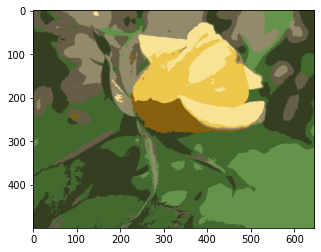

In [6]:
sample_k4 = image_RGBi_to_RGBf(images[5])
sample_k4_result, labels, centers = k_means_cluster(sample_k4, 8)

plt.imshow(sample_k4_result)
plt.show()

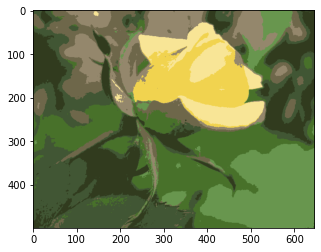

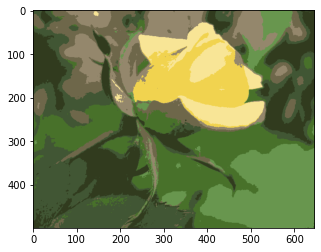

In [7]:
sample_c4 = image_RGBi_to_RGBf(images[5])
sample_c4_result, labels, centers = c_means_cluster(sample_c4, 8)

plt.imshow(sample_c4_result)
plt.show()

## Key Color Translation
Kode di bawah adalah bagian di mana warna yang telah dipilih melalui clustering digeser dengan confusion line sebagai panduan

In [8]:
from math import atan
import numpy as np

cpoint_prot = [0.763, 0.236]
cpoint_deut = [1.4, -0.4]

def pol_to_cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

def get_confusion_lines(n_lines, cross_point):
    xy_red = [0.639999925519409, 0.33000006827387507]
    xy_blue = [0.15000000831312826, 0.060000003325251315]
    PI = 3.14159265
    m_prot_red = (cross_point[1] - xy_red[1]) / (cross_point[0] - xy_red[0])
    angle_red = atan(m_prot_red)
    m_prot_blue = (cross_point[1] - xy_blue[1]) / (cross_point[0] - xy_blue[0])
    angle_blue = atan(m_prot_blue)
    angle = abs(angle_red - angle_blue)
    increment = angle / (n_lines - 1)

    res = []
    res.append(xy_red)
    cur_angle = angle_red
    for i in range(n_lines - 2):
        cur_angle += increment
        x, y = pol_to_cart(0.5, cur_angle)
        res.append([x + cross_point[0], y + cross_point[1]])
    res.append(xy_blue)
    return res

Kode berikut adalah kode untuk komputasi geometris (point to line distance dan point to line projection) yang akan digunakan saat melakukan image recoloring dengan menggunakan confusion lines

In [9]:
import math

def point_to_line_dist(pt_line1, pt_line2, point):
    
    y1 = pt_line1[1]
    y2 = pt_line2[1]
    x1 = pt_line1[0]
    x2 = pt_line2[0]

    y0 = point[1]
    x0 = point[0]

    m = (y2 - y1) / (x2 - x1)
    a = -m
    b = 1
    c = m * x1 - y1

    return abs(a * x0 + b * y0 + c) / math.sqrt(a * a + b * b)

def point_to_line_proj(pt_line1, pt_line2, point):
    
    y1 = pt_line1[1]
    y2 = pt_line2[1]
    x1 = pt_line1[0]
    x2 = pt_line2[0]

    y0 = point[1]
    x0 = point[0]

    m1 = (y2 - y1) / (x2 - x1)
    m2 = -(1 / m1)
    c1 = m1 * x1 - y1
    c2 = m2 * x0 - y0

    x = (c2 - c1) / (m2 - m1)
    y = m2 * x - c2

    return x, y

In [10]:
cpoint_prot = [0.763, 0.236]
cpoint_deut = [1.4, -0.4]

def translate(image, n_cluster, n_line, mode = "protanopia", cluster = "k_means"):

    if cluster == "k_means":
        clustered, labels, centers = k_means_cluster(image, n_cluster)
    if cluster == "c_means":
        clustered, labels, centers = c_means_cluster(image, n_cluster)

    centers_xyY = []
    for i in range(n_cluster):
        centers_xyY.append(point_RGB_to_xyY(centers[i]))

    cross_point = cpoint_prot
    if (mode == "deutranopia"):
        cross_point = cpoint_deut

    lines = get_confusion_lines(n_line, cross_point)

    used = []
    for i in range(n_line):
        used.append(0)

    new_centers = []
    for i in range(n_cluster):
        min_val = 10.0
        min_id = -1
        for j in range(n_line):
            dist = point_to_line_dist(cross_point, lines[j], centers_xyY[i][:2])
            if (dist < min_val and used[j] == 0):
                min_id = j
                min_val = dist
        x, y = point_to_line_proj(cross_point, lines[min_id], centers_xyY[i][:2])
        new_centers.append([x, y, centers_xyY[i][2]])
        used[min_id] = 1
    
    res_image = np.zeros(image.shape)
    index = 0
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            res_image[row][col][0] = new_centers[labels[index]][0]
            res_image[row][col][1] = new_centers[labels[index]][1]
            res_image[row][col][2] = new_centers[labels[index]][2]
            index += 1
    RGB_image = image_xyY_to_RGB(res_image)
    
    return RGB_image, clustered

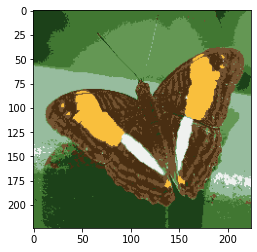

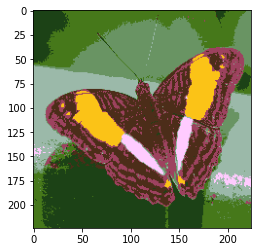

In [11]:
sample_4 = image_RGBi_to_RGBf(images[8])
sample_4_result, sample_4_clustered = translate(sample_4, 8, 14, "protanopia", "k_means")

plt.imshow(sample_4_clustered)
plt.show()
plt.imshow(sample_4_result)
plt.show()

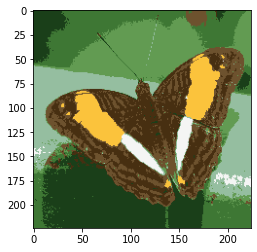

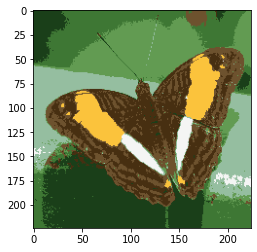

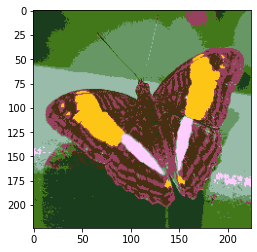

In [12]:
sample_8 = image_RGBi_to_RGBf(images[0])
sample_8_result, sample_8_clustered = translate(sample_4, 8, 14, "protanopia", "c_means")

plt.imshow(sample_8_clustered)
plt.show()
plt.imshow(sample_8_result)
plt.show()

## Image Recoloring
Terakhir, perubahan yang telah diterapkan ke key color akan diterapkan ke citra asli

In [13]:
from skimage import io, color

def recoloring(original_RGB, clustered_RGB, translated_RGB):

    original_lab = color.rgb2lab(original_RGB)
    clustered_lab = color.rgb2lab(clustered_RGB)
    translated_lab = color.rgb2lab(translated_RGB)

    result_lab = np.array(original_RGB.shape)
    
    result_lab = translated_lab - clustered_lab
    result_lab = result_lab + original_lab

    result_rgb = color.lab2rgb(result_lab)

    return result_rgb

Kode yang menyatukan semua fungsi dan proses yang telah dibuat

In [14]:
def recoloring_for_CVD(image, n_cluster, n_line, mode = "protanopia", cluster = "k_means"):
    translated, clustered = translate(image, n_cluster, n_line, mode, cluster)
    return recoloring(image, clustered, translated)

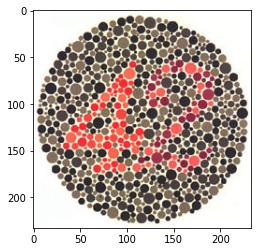

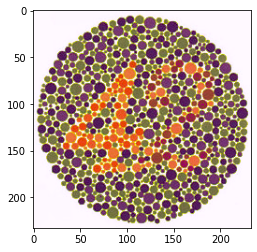

In [15]:
sample_4 = image_RGBi_to_RGBf(images[0])
sample_4_result = recoloring_for_CVD(sample_4, 4, 7, "protanopia", "k_means")

plt.imshow(sample_4)
plt.show()
plt.imshow(sample_4_result)
plt.show()

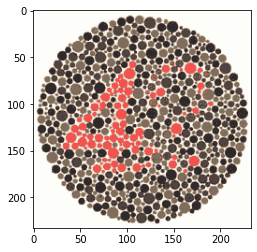

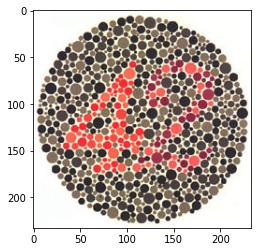

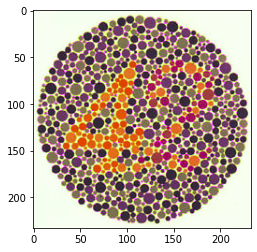

In [16]:
sample_8 = image_RGBi_to_RGBf(images[0])
sample_8_result = recoloring_for_CVD(sample_8, 8, 14, "protanopia", "c_means")

plt.imshow(sample_8)
plt.show()
plt.imshow(sample_8_result)
plt.show()

## Image Sample Generation

In [17]:
def show_samples(images, parameters, mode = "protanopia", cluster = "k_means"):
    for image in images:
        _image = image_RGBi_to_RGBf(image)
        plt.imshow(_image)
        plt.show()
        for parameter in parameters:
            result = recoloring_for_CVD(_image, parameter[0], parameter[1], mode)
            plt.imshow(result)
            plt.show()

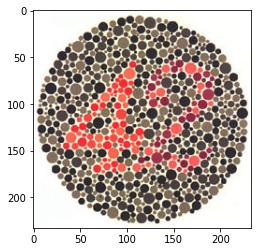

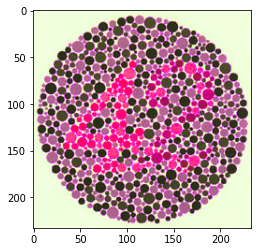

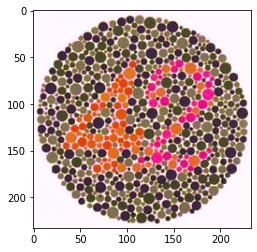

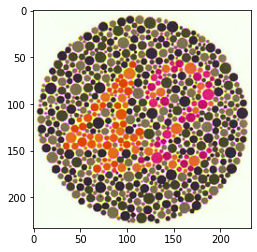

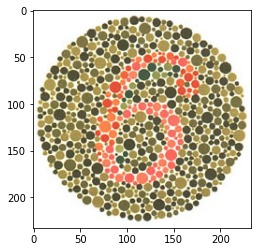

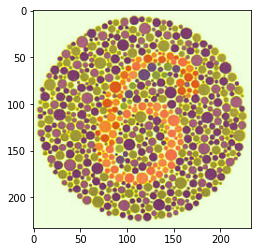

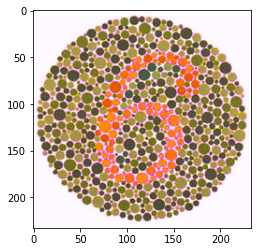

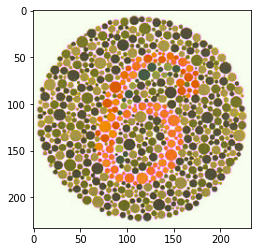

In [18]:
parameters = [[4, 8], [8, 11], [8, 14]]

show_samples(images[:2], parameters, "protanopia", "k_means")

In [19]:
def save_samples(images, parameters, mode = "protanopia", cluster = "k_means"):
    result_link = 'drive/MyDrive/[Bimbingan] S1 LR/~2122Genap Naufal Tanansyah CVD Enhancement/Dataset/Images_final_v2'
    index_image = 0
    for image in images:
        _image = image_RGBi_to_RGBf(image)
        for parameter in parameters:
            result = recoloring_for_CVD(_image, parameter[0], parameter[1], mode, cluster)
            _result = image_RGBf_to_RGBi(result)
            io.imsave(result_link + '/' + mode + '_' + cluster + '_0' + str(index_image) + '_' + str(parameter[0]) + '_' + str(parameter[1]) + '.jpg', _result)
        index_image += 1

In [20]:
save_samples(images, parameters, 'protanopia', "k_means")
save_samples(images, parameters, 'protanopia', "c_means")
#save_samples(images, parameters, 'deutranopia')

KeyboardInterrupt: ignored

In [21]:
def save_experiment(images, parameters, mode = "protanopia"):
    result_link = 'drive/MyDrive/[Bimbingan] S1 LR/~2122Genap Naufal Tanansyah CVD Enhancement/Dataset/Prelim_experiment_2'
    index_image = 0
    for image in images:
        _image = image_RGBi_to_RGBf(image)
        for parameter in parameters:
            result = recoloring_for_CVD(_image, parameter[0], parameter[1], mode)
            _result = image_RGBf_to_RGBi(result)
            io.imsave(result_link + '/' + mode + '_0' + str(index_image) + '_' + str(parameter[0]) + '_' + str(parameter[1]) + '.jpg', _result)
        index_image += 1

In [22]:
exp_param = []
for i in range(2, 11):
    for j in range(i, 21):
        exp_param.append([i, j])

#save_experiment(images, exp_param, 'protanopia')

<ipython-input-41-ad45bce685c4>:7: UserWarning: drive/MyDrive/[Bimbingan] S1 LR/~2122Genap Naufal Tanansyah CVD Enhancement/Dataset/subway_result.jpg is a low contrast image
  result_link = io.imsave('drive/MyDrive/[Bimbingan] S1 LR/~2122Genap Naufal Tanansyah CVD Enhancement/Dataset/subway_result.jpg', _subway_res)


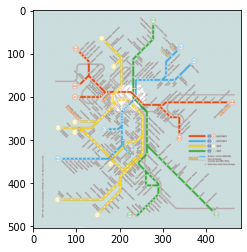

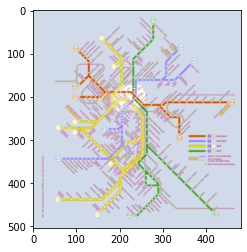

In [41]:
subway_link = 'drive/MyDrive/[Bimbingan] S1 LR/~2122Genap Naufal Tanansyah CVD Enhancement/Dataset/Subway_Vienot_path_only.jpg'

subway_img = image_RGBi_to_RGBf(io.imread(subway_link))
subway_res = recoloring_for_CVD(subway_img, 8, 11, "protanopia", "k_means")
_subway_res = image_RGBf_to_RGBi(subway_res)

result_link = io.imsave('drive/MyDrive/[Bimbingan] S1 LR/~2122Genap Naufal Tanansyah CVD Enhancement/Dataset/subway_result.jpg', _subway_res)

plt.imshow(subway_img)
plt.show()
plt.imshow(subway_res)
plt.show()